<a href="https://colab.research.google.com/github/w-nityammm/QBHit/blob/main/QBHit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install librosa numpy scipy matplotlib pydub fastdtw essentia mir_eval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/13.7 MB 21.4 MB/s eta 0:00:01Downloading essentia-2.1b6.dev1110-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 3.7 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542094 sha256=7ac3bb3dcc44042be01c85836d7b4803e72809152a453e8502a448aaecc1ea5f
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw
  Created wheel for fastdtw: filename=

In [24]:
import librosa
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import matplotlib.pyplot as plt
import essentia.standard as es
from mir_eval.sonify import pitch_contour
from google.colab import output
import base64
from pydub import AudioSegment
import io
import tempfile
import time
import IPython
from IPython.display import Audio, display, Javascript


In [61]:
# Step 1: Define a function to extract features (MFCC and Chroma)
def extract_features(file_path):

    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    return mfcc, chroma, spectral_contrast, tempo

def compare_features(hummed_features, song_features):

    hummed_mfcc, hummed_chroma, hummed_spectral_contrast, hummed_tempo = hummed_features
    song_mfcc, song_chroma, song_spectral_contrast, song_tempo = song_features

    distance_mfcc, _ = fastdtw(hummed_mfcc.T, song_mfcc.T, dist=euclidean)

    distance_chroma, _ = fastdtw(hummed_chroma.T, song_chroma.T, dist=euclidean)

    distance_spectral_contrast, _ = fastdtw(hummed_spectral_contrast.T, song_spectral_contrast.T, dist=euclidean)

    distance_tempo = abs(hummed_tempo - song_tempo)

    total_distance = (
        0.5 * distance_mfcc +
        0.3 * distance_chroma +
        0.15 * distance_spectral_contrast +
        0.05 * distance_tempo
    )
    return total_distance

def normalize_features(features):

    normalized_features = []
    for feature in features:
        feature = np.array(feature)
        if feature.ndim == 1:
            feature = feature[:, np.newaxis]
        mean = np.mean(feature, axis=1, keepdims=True)
        std = np.std(feature, axis=1, keepdims=True)

        normalized_features.append((feature - mean) / (std + 1e-6))
    return normalized_features


def find_best_match(hummed_features, song_features):
    """
    Finds the best match for the hummed input from the song database.
    """
    best_match = None
    min_distance = float('inf')
    for song_name, features in song_features.items():
        distance = compare_features(hummed_features, features)
        if distance < min_distance:
            min_distance = distance
            best_match = song_name
    return best_match, min_distance

In [35]:
song_database = {
    "Song1": "/content/drive/MyDrive/songs/burfict.wav",
    "Song2": "/content/drive/MyDrive/songs/360.wav",
    "Song3": "/content/drive/MyDrive/songs/either_on_or_off_the_drugs.wav",
    "Song4": "/content/drive/MyDrive/songs/flashing_lights.wav",
    "Song5": "/content/drive/MyDrive/songs/hazard_duty_pay.wav",
    "Song6": "/content/drive/MyDrive/songs/heartless.wav",
    "Song7": "/content/drive/MyDrive/songs/i_wonder.wav",
    "Song8": "/content/drive/MyDrive/songs/snooze.wav",
    "Song9": "/content/drive/MyDrive/songs/the_storm.wav"
}

In [62]:
song_features = {}
for song_name, file_path in song_database.items():
    mfcc, chroma, spectral_contrast, tempo = extract_features(file_path)
    song_features[song_name] = (mfcc, chroma, spectral_contrast, tempo)

In [37]:
recorded_audio = None

def save_recording(data):
    global recorded_audio
    recorded_audio = data

output.register_callback('notebook.saveRecording', save_recording)

def record_audio(seconds=8):
    """
    Records audio from the browser in Colab using JavaScript.
    """
    global recorded_audio
    recorded_audio = None

    js_code = f"""
    async function recordAudio(seconds) {{
        const sleep = time => new Promise(resolve => setTimeout(resolve, time));
        const stream = await navigator.mediaDevices.getUserMedia({{ audio: true }});
        const recorder = new MediaRecorder(stream);
        const chunks = [];

        recorder.ondataavailable = e => chunks.push(e.data);
        recorder.start();

        await sleep(seconds * 1000);
        recorder.stop();

        recorder.onstop = async () => {{
            const blob = new Blob(chunks, {{ type: 'audio/wav' }});
            const reader = new FileReader();

            reader.onloadend = () => {{
                const base64data = reader.result.split(',')[1]; // Extract base64 part
                document.getElementById("audio-data").value = base64data;
            }};

            reader.readAsDataURL(blob);
        }};
    }}

    if (!document.getElementById("audio-data")) {{
        var input = document.createElement("input");
        input.type = "hidden";
        input.id = "audio-data";
        document.body.appendChild(input);
    }}

    recordAudio({seconds});
    """

    print(f"Recording for {seconds} seconds...")
    display(Javascript(js_code))

    timeout = seconds + 5
    elapsed = 0
    while True:
        audio_string = output.eval_js("document.getElementById('audio-data')?.value")
        if audio_string:
            recorded_audio = audio_string
            break
        if elapsed >= timeout:
            raise RuntimeError("Recording failed or timed out.")
        time.sleep(1)
        elapsed += 1

    print("Recording finished!")
    audio_bytes = base64.b64decode(recorded_audio)
    return audio_bytes

def audio_bytes_to_np(audio_bytes, sample_rate=44100):
    audio = AudioSegment.from_file(io.BytesIO(audio_bytes))
    with tempfile.NamedTemporaryFile(suffix='.wav') as temp_wav_file:
        fname = temp_wav_file.name
        audio.export(fname, format='wav')
        audio_np, _ = librosa.load(fname, sr=sample_rate)
    return audio_np

def process_hummed_input(audio_np, sample_rate=44100):
    mfcc = librosa.feature.mfcc(y=audio_np, sr=sample_rate, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=audio_np, sr=sample_rate)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio_np, sr=sample_rate)
    tempo, _ = librosa.beat.beat_track(y=audio_np, sr=sample_rate)
    return mfcc, chroma, spectral_contrast, tempo

In [65]:
audio_bytes = record_audio(seconds=8)
audio_np = audio_bytes_to_np(audio_bytes)
display(Audio(audio_np, rate=44100))

Recording for 8 seconds...


<IPython.core.display.Javascript object>

Recording finished!


In [66]:
hummed_features = process_hummed_input(audio_np)
hummed_features = normalize_features(hummed_features)
song_features_normalized = {name: normalize_features(features) for name, features in song_features.items()}

In [67]:
def find_best_match(hummed_features, song_features):
    best_match = None
    min_distance = float('inf')

    for song_name, features in song_features.items():
        distance = compare_features(hummed_features, features)
        print(f"{song_name}: Distance = {distance}")

        if distance < min_distance:
            min_distance = distance
            best_match = song_name

    print(f"Best Match: {best_match} with distance: {min_distance}\n")
    return best_match, min_distance


best_match, distance = find_best_match(hummed_features, song_features_normalized)
print(f"Best Match: {best_match} with distance: {distance}")


=== Song Matching Debug ===
Song1: Distance = [[46520.70575715]]
Song2: Distance = [[45857.10692378]]
Song3: Distance = [[47161.41964846]]
Song4: Distance = [[78086.73630673]]
Song5: Distance = [[52795.14309541]]
Song6: Distance = [[71453.33527807]]
Song7: Distance = [[79855.07639572]]
Song8: Distance = [[64143.88955679]]
Song9: Distance = [[76007.30022473]]
Best Match: Song2 with distance: [[45857.10692378]]

Best Match: Song2 with distance: [[45857.10692378]]


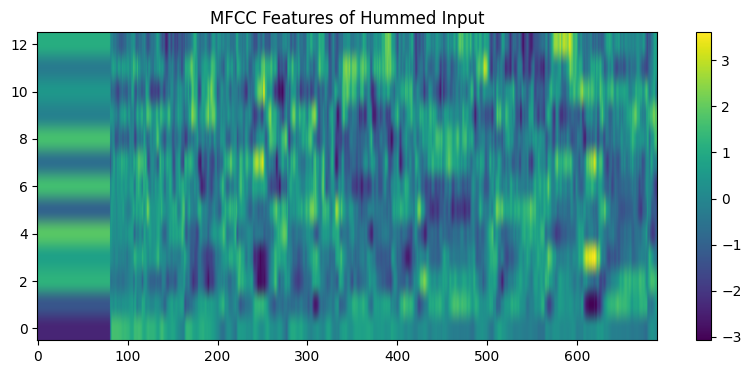

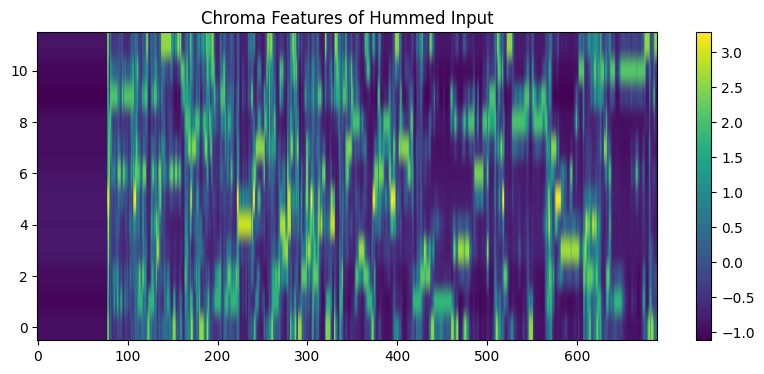

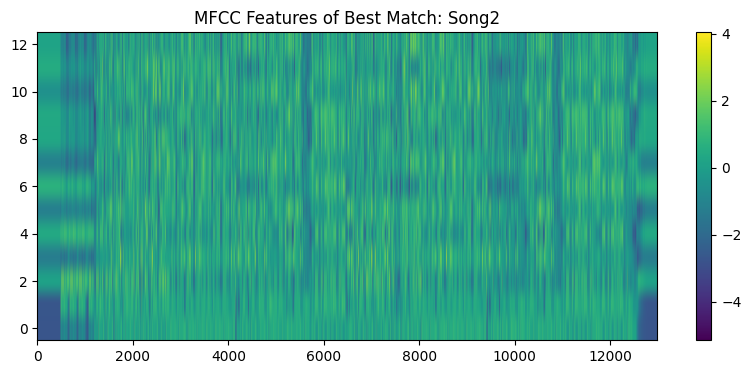

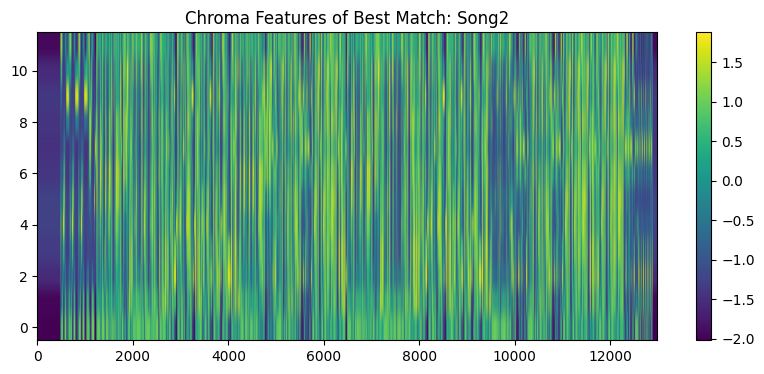

In [59]:
def plot_features(features, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(features, aspect='auto', origin='lower')
    plt.title(title)
    plt.colorbar()
    plt.show()

plot_features(hummed_features[0], "MFCC Features of Hummed Input")
plot_features(hummed_features[1], "Chroma Features of Hummed Input")
best_match_features = song_features_normalized[best_match]
plot_features(best_match_features[0], f"MFCC Features of Best Match: {best_match}")
plot_features(best_match_features[1], f"Chroma Features of Best Match: {best_match}")